# WSI Reading and Visualisation Example

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/example_wsiread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_wsiread.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

*Note*: This notebook assumes that `tiatoolbox` has already been installed. If it isn't, you can install it to your python environment by following guideline from https://github.com/TIA-Lab/tiatoolbox or you can install the stable release by running the cell below.

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools

In [ ]:
!pip install tiatoolbox

Welcome to tiatoolbox. This is an example to read a whole slide image (WSI) using tiatoolbox. We will load a sample whole slide image (WSI), check out some key information, then extract some image patches from it. From this, we will examine `wsireader` and `slide_info` modules of the library.

We will start by importing some libraries required to run this notebook examples.

In [1]:
from tiatoolbox.dataloader import wsireader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

To start with, we will load a small WSI. This WSI is provided by the user using the path variable  `user_sample_wsi_path`. By default, the value is `None` and the WSI will be downloaded from the web using the provided links instead. When downloading from the web, the WSI will be saved under `data_dir` with the named provided in `sample_file_name`. Additionally, data generated by the notebook will also be stored under `data_dir`. Users should change the `data_dir` to their preferred location.

In [2]:
data_dir = './tmp'
sample_file_name = 'sample_wsi_small.svs'

user_sample_wsi_path = None

if user_sample_wsi_path is None:
    sample_wsi_path = '%s/%s' % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
if not os.path.exists(sample_wsi_path):
    os.mkdir(data_dir)
    r = requests.get(
        "http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs"
    )
    with open(sample_wsi_path, "wb") as f:
        f.write(r.content)

Now, we will create an `OpenSlideWSIReader` object to load information from the WSI. For this class, the `input_path` is the path pointing to the WSI, while the `output_dir` gives a directory for storing intermediate outputs.

In [3]:
# create a file handler
wsi_reader = wsireader.get_wsireader(
                input_img=sample_wsi_path)

First, let's check the basic WSI information, such as magnification, dimension, etc.

In [4]:
wsi_info = wsi_reader.info.as_dict()
# we will print out each info line by line
print(*list(wsi_info.items()), sep='\n')

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', WindowsPath('tmp/sample_wsi_small.svs'))


We can also load the WSI thumbnail using the `slide_thumbnail` method of the object. The thumbnail can be loaded with different resolution units. For the units, there are:

- `mpp`: microns per pixel
- `power`: objective power of the scanner
- `level`: the level in within the WSI pyramidal file
- `baseline`: pixels per baseline pixel

We will load the thumbnail at x1.25 objective power as follows:

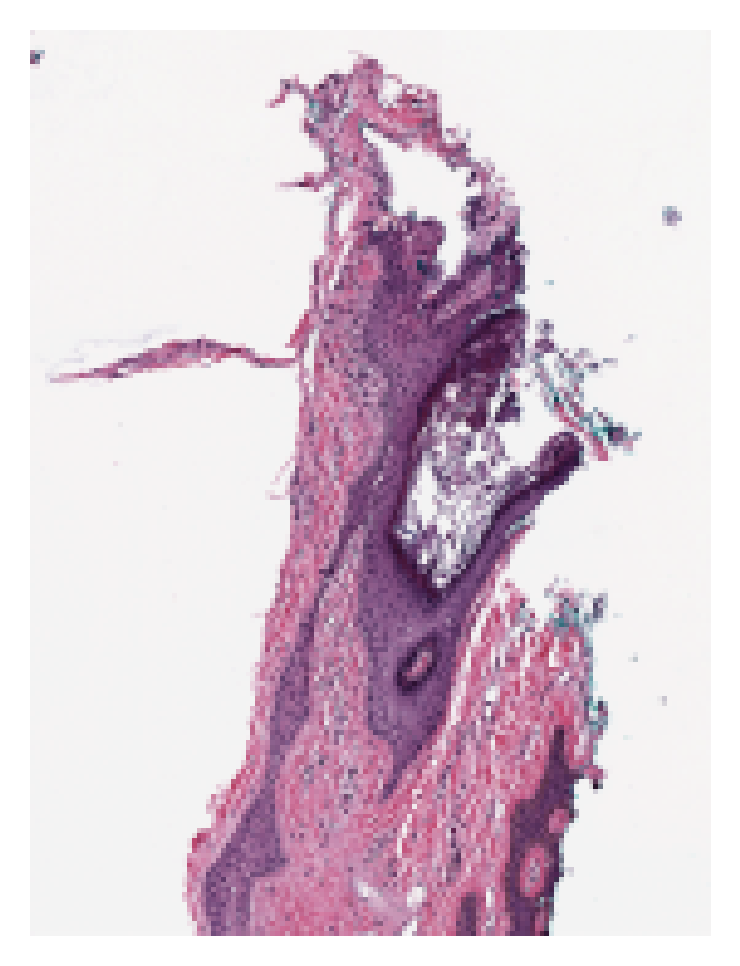

In [5]:
wsi_thumb = wsi_reader.slide_thumbnail(resolution=1.25, units='power')
plt.imshow(wsi_thumb)
plt.axis('off')
plt.show()


Now, we will see how to use the WSI object by implementing a small task:

*  Get a set of locations from the tissue areas of the WSI thumbnail
* Visualise patches we got previously then load the patches up for visualization.

In order to select only patches within tissue areas, we implement a `simple_get_mask` function to threshold the WSI thumbnail intensity and consequently separate the tissue from the background. Here, we use some extra morphological operations, such as dilation, to refine the output. We often call the area to highlight a specific region in the image a **mask**.

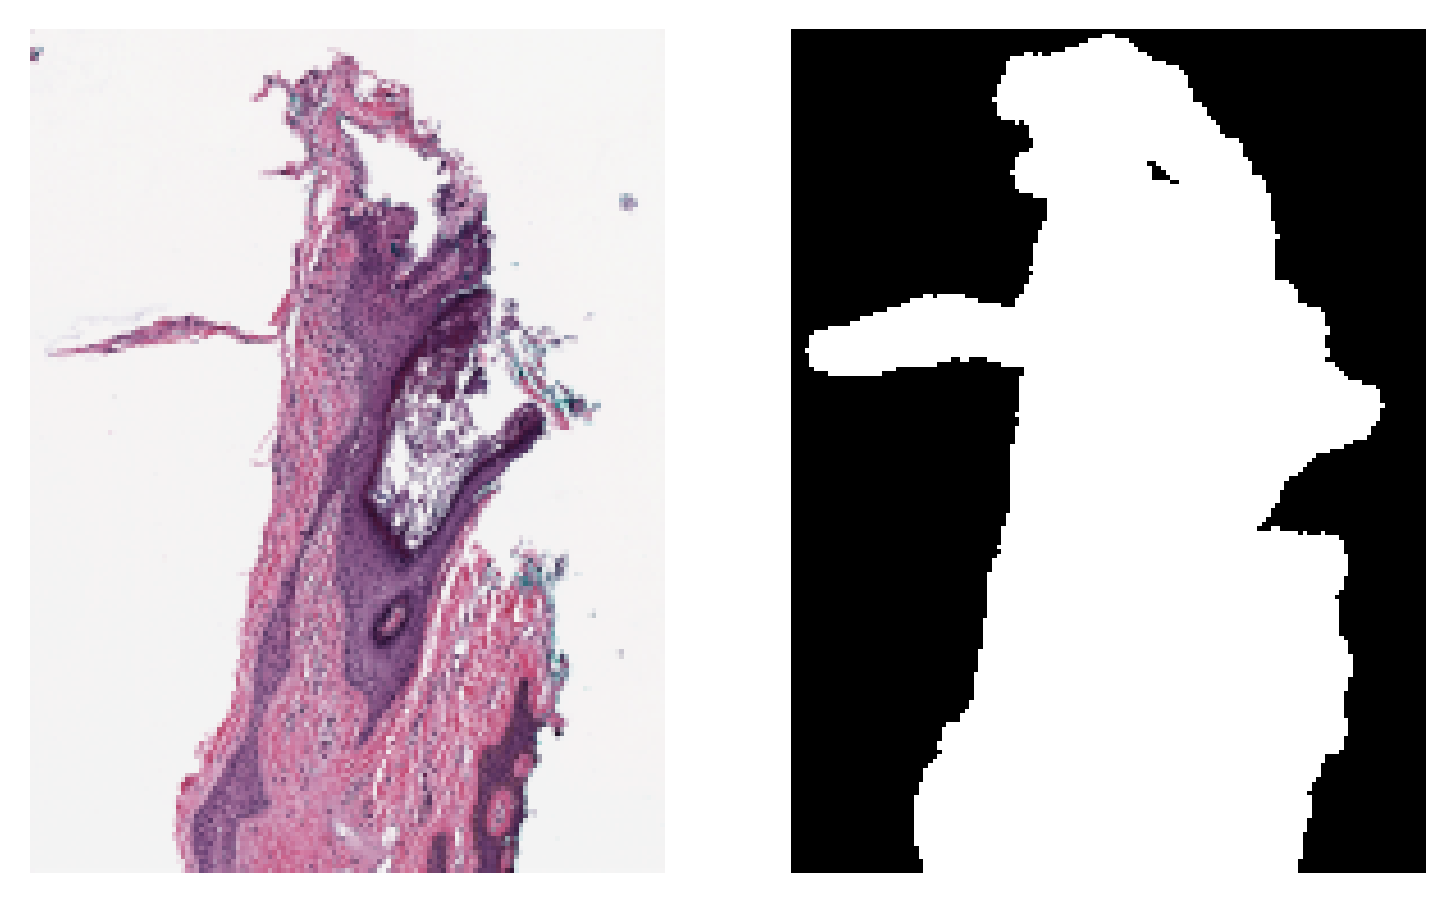

In [6]:
import math, cv2
from skimage import morphology

# an example function using intensity thresholding and morphological operations to obtain tissue regions
def simple_get_mask(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) # threshold using OTSU method
    mask = morphology.remove_small_objects(mask == 0, min_size=100, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(5))
    return mask

# plot thumbnail along with its tissue mask
wsi_thumb_mask = simple_get_mask(wsi_thumb)
plt.subplot(1,2,1)
plt.imshow(wsi_thumb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(wsi_thumb_mask, cmap='gray')
plt.axis('off')
plt.show()

Now, we can write a function to obtain a set of locations from where to extract the patches within the tissue area. The location is defined as the top left coordinates of the source image, along with its corresponding dimensions (height and width). For computational reasons, this operation is done at the thumbnail level (low resolution) and so we will need to map the patch locations and dimensions to the magnification level that we intend to use for patch extraction.

In [7]:
from scipy.ndimage.measurements import center_of_mass
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# get the super-pixels (a.k.a rois) of the tissue area and extract
# patches centering those super-pixel (a.k.a rois)
lores_mag = 1.25 # the magnification of the thumbnail (lores = low resolution)
hires_mag = 20 # the magnification where the patch would be extracted (hires = high resolution)
hires_patch_size = 128 # expected output patch size at higher resolution
# map the expected patch size at hires to lores
lores_patch_size = int(hires_patch_size / (hires_mag / lores_mag))


For this example, we would like to create image patches such that they cover the entire WSI. We will use the super-pixel algorithm *SLIC* from `scikit` to do this. It will split the tissue region into regions of similar size at a low resolution. Then we get the patches which are centred at these regions. We also calculate the expected number of patches that can be obtained with the given size. However, note that the actual number of patches may not be the same as the expected number.

#Actual Patches / #Expected Patches : 203/202


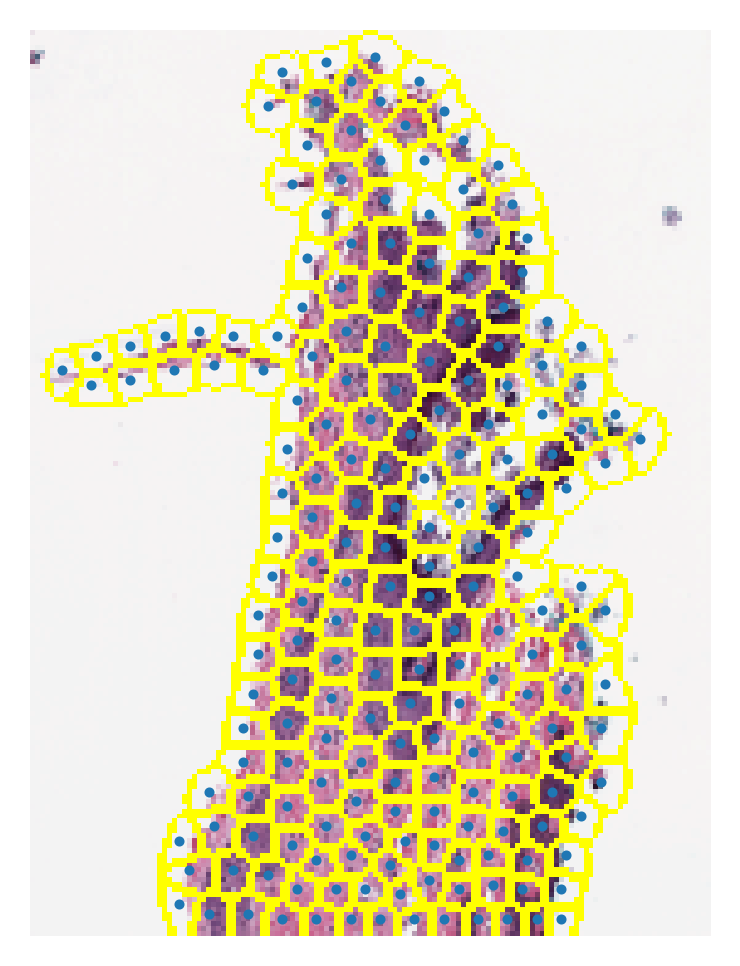

In [8]:
nr_expected_rois = math.ceil(np.sum(wsi_thumb_mask) / (lores_patch_size ** 2))
wsi_rois_mask = slic(wsi_thumb,
                    mask=wsi_thumb_mask,
                    n_segments=nr_expected_rois,
                    compactness=1000,
                    sigma=1)
print('#Actual Patches / #Expected Patches : %d/%d' % (np.unique(wsi_rois_mask).shape[0], nr_expected_rois))

lores_rois_center = center_of_mass(wsi_rois_mask,
                labels=wsi_rois_mask,
                index=np.unique(wsi_rois_mask)[1:])
lores_rois_center = np.array(lores_rois_center) # coordinates is Y, X
lores_rois_center = lores_rois_center.astype(np.int32)
selected_indices = wsi_thumb_mask[lores_rois_center[:,0],lores_rois_center[:,1]]
lores_rois_center = lores_rois_center[selected_indices]

# show the patches region and their centres of mass
plt.imshow(mark_boundaries(wsi_thumb, wsi_rois_mask))
plt.scatter(lores_rois_center[:,1], lores_rois_center[:,0], s=2)
plt.axis('off')
plt.show()


We then convert the centres of each region to the top-left position of the patches at high resolution.

In [9]:
# convert to top left idx at hires_mag level
lores_rois_top_left = (lores_rois_center - (lores_patch_size // 2))
hires_rois_top_left = lores_rois_top_left * (hires_mag / lores_mag)
hires_rois_top_left = hires_rois_top_left.astype(np.int32)

We will now load some patches for visualisation.

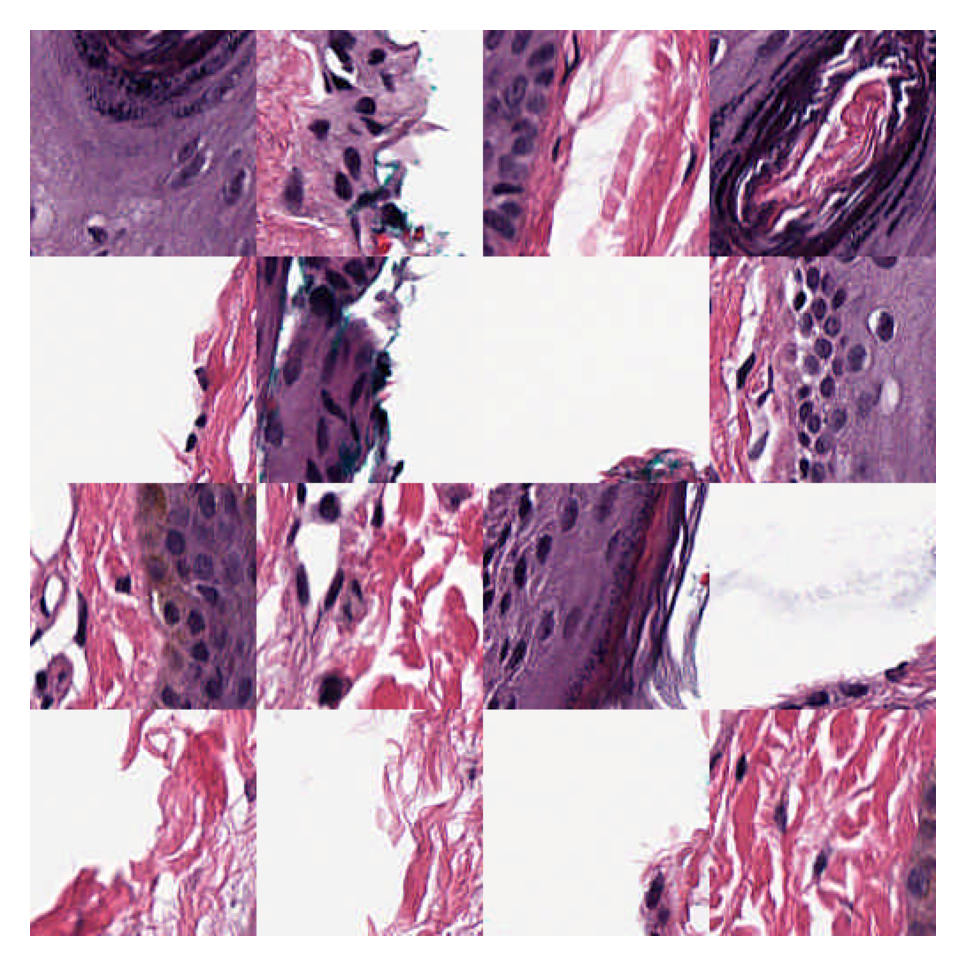

In [10]:
nr_viz_patches = 16

# for illustration purpose, we only visualise a small number of examples
selected_indices = np.random.randint(0, hires_rois_top_left.shape[0], size=(4*nr_viz_patches,))
hires_rois_top_left = hires_rois_top_left[selected_indices]

patch_list = []
for patch_coord in hires_rois_top_left:
    patch = wsi_reader.read_region(
                location=patch_coord[::-1],
                level=0, size=hires_patch_size)
    patch_list.append(patch)

# plot the first 16
sub_patches = np.array(patch_list[:16])
sub_patches = np.reshape(sub_patches, (4, 4, hires_patch_size, hires_patch_size, 3))
sub_patches = np.transpose(sub_patches, (0, 2, 1, 3, 4))
sub_patches = np.reshape(sub_patches, (4 * hires_patch_size, 4 * hires_patch_size, 3))
plt.imshow(sub_patches)
plt.axis('off')
plt.show()


Conversely, if you want to extract the entire WSI (including the background), you can use the built-in `save_tiles` functionality of the `WSIReader` object.

We start by creating another `WSIReader` object and then save tiles using save_tiles function with the keywords `tile_objective_value`, `tile_read_size` and `output_dir`. These correspond to the magnification set for reading patches, their expected width & height and the output destination. For clarity, **tile** refers to very large image patches. For this, tiles are read at 20x objective magnification, each of size 1000x1000, and will be saved at the `tmp` folder within the `run_dir`.

In [11]:
# create a file handler
wsi_reader_v2 = wsireader.get_wsireader(
                input_img=sample_wsi_path
                )
wsi_reader_v2.save_tiles(
                output_dir=data_dir + '/output/',
                tile_objective_value=20,
                tile_read_size=(1000, 1000)
                )


Tile0:  start_w:0, end_w:1000, start_h:0, end_h:1000, width:1000, height:1000
Tile1:  start_w:1000, end_w:2000, start_h:0, end_h:1000, width:1000, height:1000
Tile2:  start_w:2000, end_w:2220, start_h:0, end_h:1000, width:220, height:1000
Tile3:  start_w:0, end_w:1000, start_h:1000, end_h:2000, width:1000, height:1000
Tile4:  start_w:1000, end_w:2000, start_h:1000, end_h:2000, width:1000, height:1000
Tile5:  start_w:2000, end_w:2220, start_h:1000, end_h:2000, width:220, height:1000
Tile6:  start_w:0, end_w:1000, start_h:2000, end_h:2967, width:1000, height:967
Tile7:  start_w:1000, end_w:2000, start_h:2000, end_h:2967, width:1000, height:967
Tile8:  start_w:2000, end_w:2220, start_h:2000, end_h:2967, width:220, height:967


Now, we will check the content of the output folder and plot some tiles for visualization. The extracted tiles would be saved under the folder at `{data_dir}/output/{sample_file_name}`. The folder would contain a Output.csv which summarizes the extracted tiles.

In [12]:
import pandas as pd

tile_summary = pd.read_csv('{data_dir}/output/{sample_file_name}/Output.csv'.format(
                                data_dir=data_dir, sample_file_name=sample_file_name))
print(tile_summary)


   iter              Tile_Name  start_w  end_w  start_h  end_h  size_w  size_h
0     0        Tile_20_0_0.jpg        0   1000        0   1000    1000    1000
1     1     Tile_20_1000_0.jpg     1000   2000        0   1000    1000    1000
2     2     Tile_20_2000_0.jpg     2000   2220        0   1000    1000     220
3     3     Tile_20_0_1000.jpg        0   1000     1000   2000    1000    1000
4     4  Tile_20_1000_1000.jpg     1000   2000     1000   2000    1000    1000
5     5  Tile_20_2000_1000.jpg     2000   2220     1000   2000    1000     220
6     6     Tile_20_0_2000.jpg        0   1000     2000   2967     967    1000
7     7  Tile_20_1000_2000.jpg     1000   2000     2000   2967     967    1000
8     8  Tile_20_2000_2000.jpg     2000   2220     2000   2967     967     220


 We will plot `Tile_20_1000_1000.jpg` as an example.

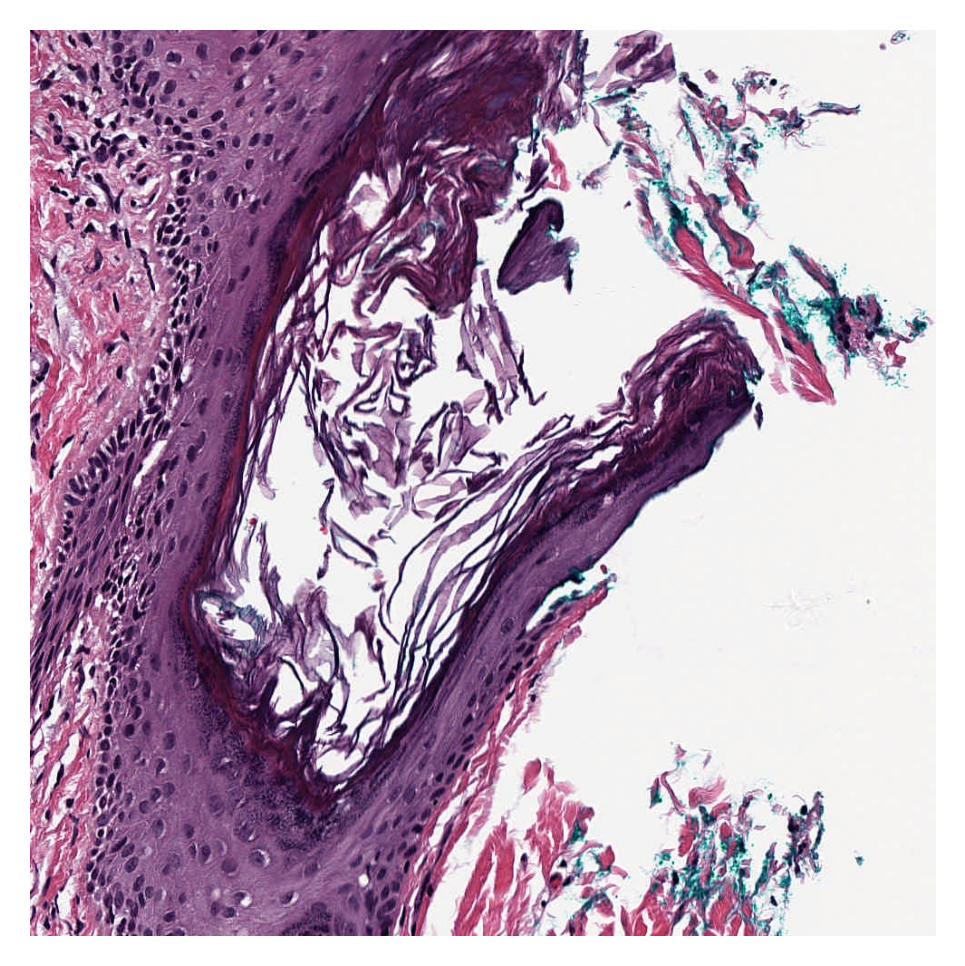

In [13]:
sample_tile = cv2.imread('%s/output/%s/%s' % (data_dir, sample_file_name, tile_summary.iloc[4]['Tile_Name']))
sample_tile = cv2.cvtColor(sample_tile, cv2.COLOR_BGR2RGB)

plt.imshow(sample_tile)
plt.axis('off')
plt.show()


The library also provides support for reading WSI in `jp2` format via `OmnyxJP2WSIReader` class. This class has the same interface as the class `OpenSlideWSIReader`. We will briefly illustrate this by downloading a `jp2` WSI from the internet and plot its thumbnail.

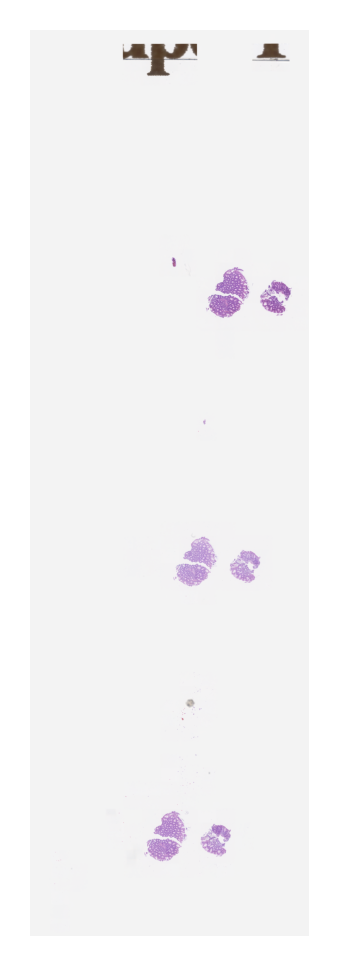

In [14]:

sample_wsi_path = '%s/sample_jp2.jp2' % data_dir
if not os.path.exists(sample_wsi_path):
    r = requests.get(
        "https://warwick.ac.uk/fac/sci/dcs/research/tia/tiatoolbox/files/test2.jp2"
    )
    with open(sample_wsi_path, "wb") as f:
        f.write(r.content)

wsi_reader = wsireader.get_wsireader(
                input_img=sample_wsi_path)
wsi_thumb = wsi_reader.slide_thumbnail(resolution=1.25, units='power')
plt.imshow(wsi_thumb)
plt.axis('off')
plt.show()